In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import pymc3 as pm
import pandas as pd

%matplotlib inline

RANDOM_SEED =58

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = (pd.read_csv('./sintered_modulus.csv'))
df['mat_code'] = df['material'].map({'Fe': 0 , 'DiSA':1, 'ACrM':2})
df['Er']=df.E/212
df

,density,E,G,rho_r,porosity,Er,material,mat_code
0,6.814,135.5,54.40,0.867,0.133,0.639151,Fe,0
1,6.854,135.5,54.40,0.872,0.128,0.639151,Fe,0
2,6.828,135.5,54.80,0.869,0.131,0.639151,Fe,0
3,6.838,135.9,54.60,0.870,0.130,0.641038,Fe,0
4,6.847,137.4,54.70,0.871,0.129,0.648113,Fe,0
5,6.814,135.6,54.70,0.867,0.133,0.639623,Fe,0
6,6.963,146.2,58.80,0.886,0.114,0.689623,Fe,0
7,6.998,144.0,57.80,0.890,0.110,0.679245,Fe,0
8,6.993,146.6,58.90,0.890,0.110,0.691509,Fe,0
9,7.019,147.0,59.00,0.893,0.107,0.693396,Fe,0


In [3]:
dfFe = (pd.read_csv('./sintered_modulus_Fe.csv'))
dfFe['Er']=dfFe.E/212
dfFe

,nom,pho,porosity,E,Er
0,1,6.729887,0.143780,135.586000,0.639557
1,2,6.666999,0.151781,135.056333,0.637058
2,3,6.740978,0.142369,136.063333,0.641808
3,4,6.731806,0.143536,135.612667,0.639682
4,5,6.744366,0.141938,137.058667,0.646503
5,6,6.722139,0.144766,135.148667,0.637494
6,7,6.859912,0.127238,147.085333,0.693799
7,8,6.860670,0.127141,144.450333,0.681369
8,9,6.900875,0.122026,146.922667,0.693031
9,10,6.904472,0.121568,147.142000,0.694066


In [4]:
#raw_density =np.array([6.60, 6.73, 6.74,6.75,6.84, 6.89, 6.90, 6.88, 7.01,7.03]).reshape(-1,1)
#E_modulus =np.array([135.502, 136.828,136.644,137.792,148.436,147.230,147.278,147.120,147.677,158.005]).reshape(-1,1)

dfDA = df.iloc[20:,[4,5,6]]
#rel_modulus = df.loc[df.mat_code ==0 , 'Er']
#mat_code=df.mat_code.values
dfDA

,porosity,Er,material
20,0.087,0.778774,ACrM
21,0.085,0.786321,ACrM


In [6]:
# Test data
Xtrain=dfFe.porosity.values # Relative porosity
Ytrain=dfFe.Er.values
n=len(Xtrain)
n

18

In [7]:
Xdata = np.column_stack((Xtrain, Xtrain**2)) #Regressors matrix
Xdata.shape

(18, 2)

In [17]:
with pm.Model() as model:
          
    #Priors
    #E0 =pm.Normal('E0', mu=212, sd=10)
    a = pm.Normal('a', mu=1, sd=0.5)
    b = pm.Normal('b', mu=1, sd=1, shape =1)
    sigma = pm.HalfNormal('sigma', sd=0.1)
    pm.Deterministic('Pc',1/b)
    beta = [-b-a, a*b]
    
    Xshared=pm.Data('porosity', Xdata)

    #link function
    mu = 1 +pm.math.dot(Xshared, beta)

    #likelihood
    y = pm.Normal('y', mu =mu, sd= sigma, observed = Ytrain)
    
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)
    

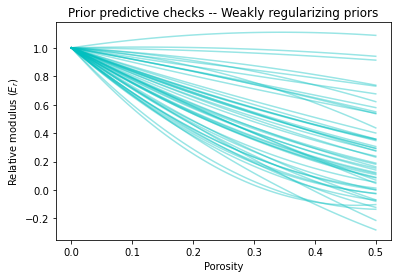

In [18]:
_, ax = plt.subplots()

x = np.linspace(0, 0.5, 50)

for a, b in zip(prior_checks["a"], prior_checks['b']):
    y = (1- a*x)*(1-b*x)
    ax.plot(x, y, c="#FF8C00", alpha=0.4)

ax.set_xlabel("Porosity")
ax.set_ylabel("Relative modulus ($E_r$)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

In [19]:
with model:
    trace=pm.sample(2000, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1415 seconds.


In [20]:
import arviz as az


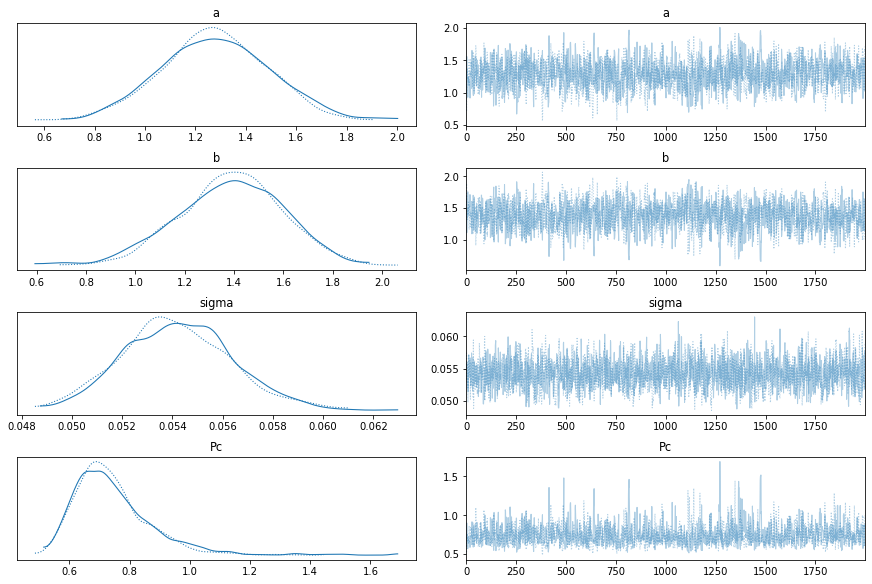

In [21]:
az.plot_trace(trace);

In [22]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.280,0.215,0.875,1.677,0.007,0.005,1082.0,1449.0,1.0
b[0],1.384,0.213,0.989,1.774,0.007,0.005,1048.0,1491.0,1.0
sigma,0.054,0.002,0.050,0.058,0.000,0.000,1786.0,1663.0,1.0
Pc[0],0.742,0.131,0.546,0.975,0.004,0.003,1048.0,1491.0,1.0


In [23]:
#Posterior predictive
Xtest =np.linspace(0, 0.5 ,50)

with model:
    pm.set_data({'porosity': np.column_stack((Xtest, Xtest**2)) })
    y_ppc = pm.sample_posterior_predictive(trace, var_names=['a',"b", "y"], random_seed=RANDOM_SEED )

In [44]:
mu_pp =[]
for a, b in zip(y_ppc["a"], y_ppc['b']):
    mu_pp.append((1- a*Xtest)*(1-b*Xtest))

mu_pp=np.array(mu_pp)
mu_pp.shape

(4000, 50)

In [26]:
mu_pp = ((1- (y_ppc["b"]+y_ppc["a"])*Xtest +y_ppc["b"]*y_ppc["a"]*Xtest**2 ))
y_ppc['y'].shape

ValueError: operands could not be broadcast together with shapes (4000,4000) (50,) 

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


(0.08, 0.16)

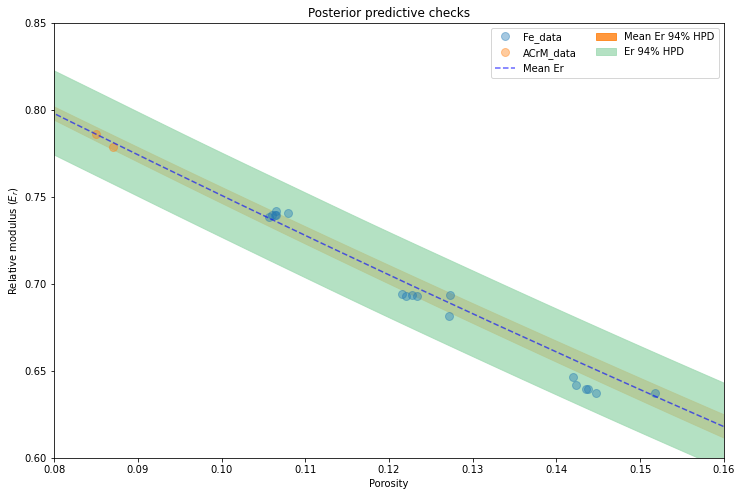

In [51]:
_, ax = plt.subplots(figsize=(12,8))

ax.plot(Xtrain, Ytrain, "o", ms=8, alpha=0.4, label="Fe_data")
ax.plot(dfDA.porosity, dfDA.Er, "o", ms=8, alpha=0.4, label="ACrM_data")
#ax.plot(Xtrain, Ytrain, "o", ms=4, alpha=0.4, label="Fe_data")
ax.plot(Xtest, mu_pp.mean(0), 'b--', label="Mean Er", alpha=0.6)
az.plot_hdi(
    Xtest,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "label": "Mean Er 94% HPD"},
)
az.plot_hdi(
    Xtest,
    y_ppc["y"].mean(2),
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Er 94% HPD"},
)

ax.set_xlabel("Porosity")
ax.set_ylabel("Relative modulus ($E_r$)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);
plt.ylim([0.6,0.85])
plt.xlim([0.08,0.16])

#plt.savefig('proba', dpi=300)

In [162]:
(y_ppc['y'].mean(1)).mean(1).shape

(4000,)

In [48]:
dfCr = (pd.read_csv('./DataAzadbeh.csv'))
dfCr['mat_code'] = dfCr['material'].map({'ACrL': 0 , 'ACrM':1})
dfCr['Er']=dfCr.E_Gpa/212
dfCr

,Nom,P%,E_Gpa,P,Er,material,mat_code
0,1,22.36,95,0.2236,0.448113,ACrL,0
1,2,15.25,130,0.1525,0.613208,ACrL,0
2,3,12.96,143,0.1296,0.674528,ACrL,0
3,4,10.80,155,0.1080,0.731132,ACrL,0
4,5,9.53,165,0.0953,0.778302,ACrL,0
5,6,21.09,102,0.2109,0.481132,ACrL,0
6,7,14.36,137,0.1436,0.646226,ACrL,0
7,8,11.82,152,0.1182,0.716981,ACrL,0
8,9,9.66,163,0.0966,0.768868,ACrL,0
9,10,8.39,173,0.0839,0.816038,ACrL,0


In [49]:
import seaborn as sns

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:title={'center':'Posterior predictive check: Cr-Mo-alloyes [] '}, xlabel='Porosity', ylabel='Relative modulus ($E_r$)'>

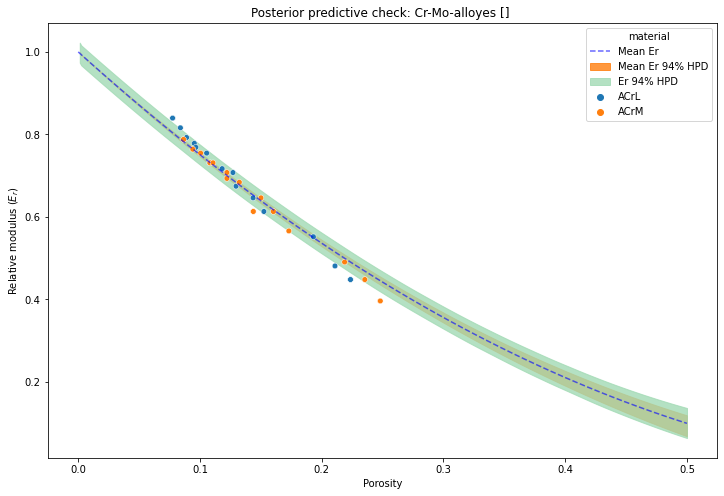

In [50]:
_, ax = plt.subplots(figsize=(12,8))

#ax.plot(Xtrain, Ytrain, "o", ms=8, alpha=0.4, label="Fe_data")
#ax.plot(dfDA.porosity, dfDA.Er, "o", ms=8, alpha=0.4, label="ACrM_data")
#ax.plot(Xtrain, Ytrain, "o", ms=4, alpha=0.4, label="Fe_data")
ax.plot(Xtest, mu_pp.mean(0), 'b--', label="Mean Er", alpha=0.6)
az.plot_hdi(
    Xtest,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "label": "Mean Er 94% HPD"},
)
az.plot_hdi(
    Xtest,
    y_ppc["y"].mean(2),
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Er 94% HPD"},
)

ax.set_xlabel("Porosity")
ax.set_ylabel("Relative modulus ($E_r$)")
ax.set_title("Posterior predictive check: Cr-Mo-alloyes [] ")
ax.legend(ncol=2, fontsize=10);
#plt.ylim([0.6,0.85])
#plt.xlim([0.08,0.16])
sns.scatterplot(x=dfCr['P'], y=dfCr['Er'], hue=dfCr['material'], marker='8')

<AxesSubplot:ylabel='Count'>

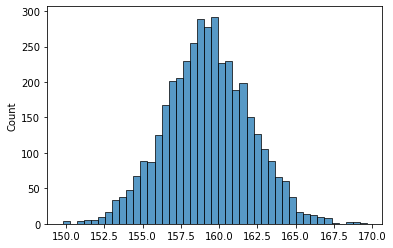

In [154]:
sns.histplot(data=((y_ppc['y'].mean(2)).mean(1))*212)

In [155]:
dfCrM = (pd.read_csv('./sintered_modulus.csv'))
dfCrM['mat_code'] = dfCrM['material'].map({'Fe': 0 , 'DiSA':1, 'ACrM':2})
dfCrM['Er']=df.E/212

abc

In [151]:
#Posterior predictive P=0.1
Xtest01 = 0.1

with model:
    pm.set_data({'porosity': np.column_stack((Xtest01, Xtest01**2)) })
    y_ppc = pm.sample_posterior_predictive(trace, var_names=["b", "y"], random_seed=RANDOM_SEED )

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


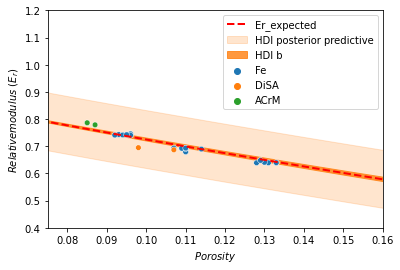

In [222]:

plt.plot(idata.constant_data.porosity.values[:,0], idata.posterior_predictive.y.mean(dim=("chain", "draw",'y_dim_1')), 'r--', lw=2,label='Er_expected')
az.plot_hdi(idata.constant_data.porosity.values[:,0] , ppc_hdi.y.T, hdi_prob=0.95, fill_kwargs={"alpha": 0.2, 'label':'HDI posterior predictive'})
az.plot_hdi(idata.constant_data.porosity.values[:,0] , ym.T,  fill_kwargs={"alpha": 0.8, 'label':'HDI b'} )
#plt.scatter(Xtrain, Ytrain,  label='data')
plt.xlabel('$Porosity$')
plt.ylabel('$Relative modulus$ ($E_r$)')
sns.scatterplot(x=df['porosity'], y=df['Er'], hue=df['material'], marker='8')
plt.xlim([0.075,0.16])
plt.ylim(0.4,1.2)
plt.legend()

In [158]:
plt.plot(idata.constant_data.porosity.values[:,0], idata.posterior_predictive.y.mean(dim=("chain", "draw",'y_dim_1')), 'r--', lw=2,label='Er_expected')
az.plot_hdi(idata.constant_data.porosity.values[:,0] , ppc_hdi.y.T, hdi_prob=0.95, fill_kwargs={"alpha": 0.2, 'label':'HDI posterior predictive'})
az.plot_hdi(idata.constant_data.porosity.values[:,0] , ym.T,  fill_kwargs={"alpha": 0.8, 'label':'HDI b'} )
#plt.scatter(Xtrain, Ytrain,  label='data')
plt.legend()
plt.xlabel('$Porosity$')
plt.ylabel('$Relative modulus$ ($E_r$)')
sns.scatterplot(x=dfCr['P'], y=dfCr['Er'], hue=dfCr['material'])

NameError: name 'idata' is not defined

In [158]:
import seaborn as sns

<AxesSubplot:xlabel='porosity', ylabel='Er'>

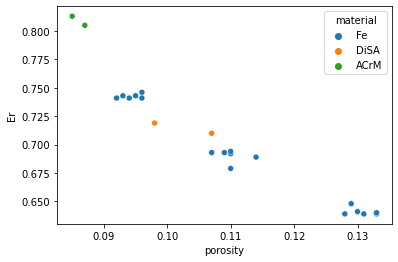

In [159]:
sns.scatterplot(x=df['porosity'], y=df['Er'], hue=df['material'])

<AxesSubplot:xlabel='Relative porosity', ylabel='Relative E modulus (Er)'>

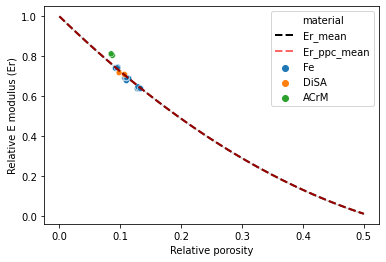

In [162]:
plt.plot(Xtest, Ytest_mean, 'k--', lw=2, label='Er_mean')
plt.gca().fill_between(Xtest.flat, yd2 , yd1, color ='#dddddd', alpha=1)
#plt.scatter(Xtrain_p,Ytrain, label='Er_data')
plt.plot(Xtest, yd.mean(axis=1), 'r--',lw=2, label="Er_ppc_mean", alpha=0.6)
plt.legend()
plt.xlabel('Relative porosity')
plt.ylabel('Relative E modulus (Er)')
sns.scatterplot(x=df['porosity'], y=df['Er'], hue=df['material'])
#plt.xlim([0, 0.2])
#plt.ylim([0.5,1])